In [121]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
from matplotlib.animation import FuncAnimation

from Ps_library_temp import *
from Hamiltonian_library import *
from krotov_custom_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':20})
rc('text', usetex=True)

"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(system.N_points*system.internal_dims,dims=[[system.N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(system.N_points):
            eigenstate = qt.tensor(qt.basis(system.N_points,n),qt.basis(2,s))
            idx = system.internal_dims*n+s
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]



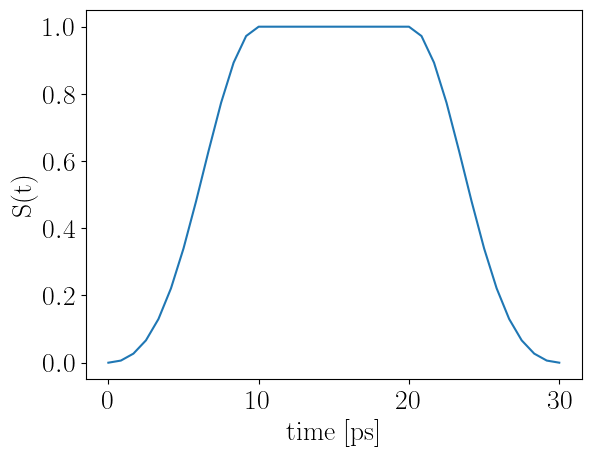

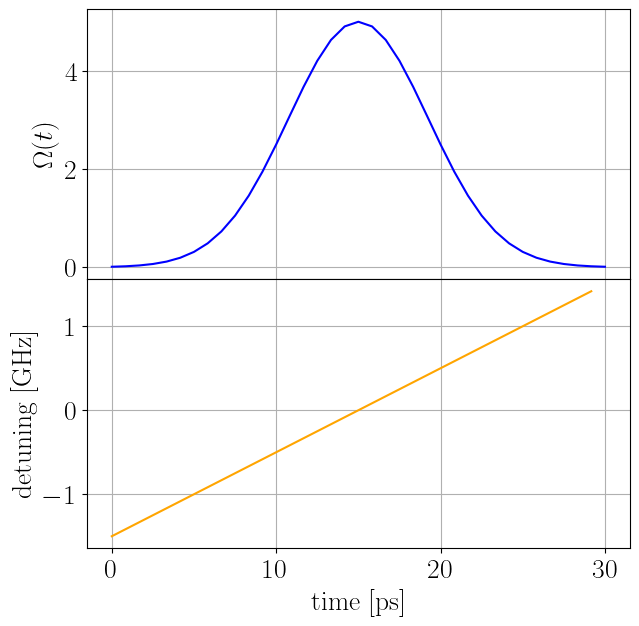

In [154]:
kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]

system = Ps_system(N_atoms =1,N_points = 200)
rabi0 = 2*np.pi*(5e-3)
chirp = 2*np.pi*(0.1e-3)
detuning = 0#2*np.pi*(250e-3)

direction = 1
pulse_duration = 10

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}

phi = args["chirp"] # laser detuning
H = []
H.append(0*qt.qeye(2)) # omega0 - omegaL0, assume laser is on-resonance
H.append([qt.Qobj([[0,0],[0,1]]),phi])
H.append([qt.sigmax(),args["rabi"]])



S = lambda t: krotov.shapes.flattop(t, t_start=0, t_stop=3*pulse_duration, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman')

pulse_options = {id(H[1][1]): dict(lambda_a=1,update_shape=S),
                 id(H[2][1]): dict(lambda_a=100,update_shape=S)}
objective = krotov.Objective(initial_state=kets[0], target=kets[1], H=H)
plt.plot(laser.tlist,[S(t) for t in laser.tlist])
plt.ylabel("S(t)")
plt.xlabel("time [ps]")
#plt.savefig("figures/thesis_draft/update_function.svg",bbox_inches="tight")
plt.show()


fig,axes = plt.subplots(2,sharex=True,gridspec_kw={"hspace":0},figsize=(7,7))
axes[0].plot(laser.tlist,args["rabi"]*1e3/(2*np.pi),color="blue")
axes[1].plot(laser.tlist[:-1],phi[:-1]*1e3/(2*np.pi),color="orange")
axes[1].set_xlabel("time [ps]")
axes[0].set_ylabel(r"$\Omega(t)$")
axes[1].set_ylabel(r"detuning [GHz]")
axes[0].grid()
axes[1].grid()
#plt.savefig("figures/thesis_draft/TLS_envelope_phase_unoptimized.svg",bbox_inches="tight")
plt.show()

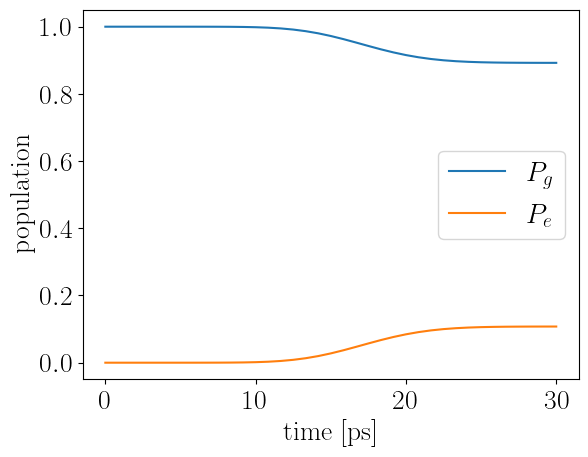

In [155]:
result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=e_ops)
#final_states = result.states[-1]
#target_states = kets[1]
#initial_states = kets[0]
# print(final_states)
# print(target_states)
# print(initial_states)
# print(krotov.functionals.chis_re(final_states,[objective],tau_vals=krotov.functionals.f_tau(final_states,[objective])))
plt.plot(laser.tlist,result.expect[0],label=r"$P_g$")
plt.plot(laser.tlist,result.expect[1],label=r"$P_e$")
plt.legend()
plt.xlabel("time [ps]")
plt.ylabel("population")
#plt.savefig("figures/thesis_draft/TLS_populations_unoptimized.svg",bbox_inches="tight")
plt.show()

In [156]:
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    )
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.92e-01    0.00e+00   8.92e-01        n/a        n/a     0
1     8.55e-01    1.52e-04   8.55e-01  -3.74e-02  -3.73e-02     0
2     8.07e-01    1.95e-04   8.07e-01  -4.78e-02  -4.76e-02     0
3     7.48e-01    2.42e-04   7.48e-01  -5.92e-02  -5.89e-02     0
4     6.78e-01    2.91e-04   6.78e-01  -7.05e-02  -7.02e-02     0
5     5.97e-01    3.33e-04   5.98e-01  -8.02e-02  -7.98e-02     0
6     5.11e-01    3.61e-04   5.11e-01  -8.64e-02  -8.60e-02     0
7     4.23e-01    3.70e-04   4.24e-01  -8.77e-02  -8.73e-02     0
8     3.40e-01    3.56e-04   3.40e-01  -8.37e-02  -8.34e-02     0
9     2.64e-01    3.22e-04   2.65e-01  -7.53e-02  -7.50e-02     0
10    2.00e-01    2.76e-04   2.01e-01  -6.40e-02  -6.38e-02     0
11    1.48e-01    2.25e-04   1.49e-01  -5.19e-02  -5.17e-02     0
12    1.08e-01    1.76e-04   1.08e-01  -4.04e-02  -4.03e-02     0
13    7.74e-02    1.33e-04   7.75e-02  -3.05e-02  -3.04e-02     0
14    5.49

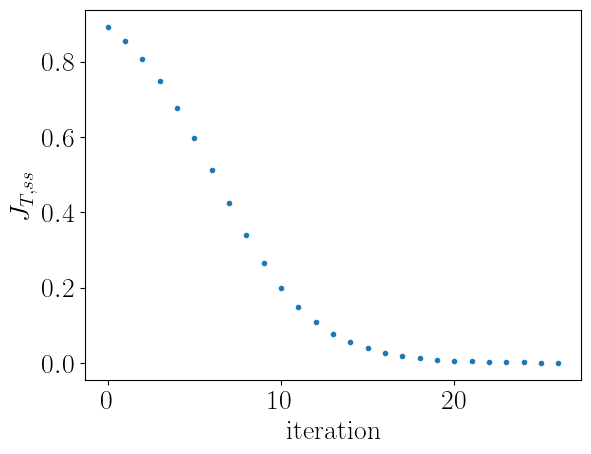

In [157]:
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=e_ops)

# fig,axes = plt.subplots(2,sharex=True,gridspec_kw={"hspace":0},figsize=(7,7))
# axes[0].plot(laser.tlist,opt_result.optimized_controls[1]*1e3/(2*np.pi),label="envelope",color="blue")
# axes[0].set_ylabel(r"$\Omega$ [GHz]")
# axes[1].grid()
# axes[0].grid()
# axes[1].plot(laser.tlist[:-2],opt_result.optimized_controls[0][:-2]*1e3/(2*np.pi),label="detuning",color="orange")
# axes[1].set_ylabel("detuning [GHz]")
#plt.savefig("figures/thesis_draft/TLS_envelope_phase_optimized.svg",bbox_inches="tight")
# plt.plot(laser.tlist, opt_dynamics.expect[0],label=r"$P_g$")
# plt.plot(laser.tlist, opt_dynamics.expect[1],label=r"$P_e$")
# plt.xlabel("time [ps]")
# plt.ylabel("Population")
# plt.legend(loc="center right", fontsize=18)
# #plt.savefig("figures/thesis_draft/TLS_populations_optimized.svg",bbox_inches="tight")

# plt.show()

#derivatives = lambda y,x: np.asarray([(y[i+1]-y[i])/(x[i+1]-x[i]) for i in range(y.size-1)])
#print(derivatives(opt_result.optimized_controls[0][:-2]*1e3/(2*np.pi),laser.tlist))
#plt.plot()

plt.plot(opt_result.iters,opt_result.info_vals,'.')
plt.ylabel(r'$J_{T,ss}$')
plt.xlabel("iteration")
#plt.savefig("figures/thesis_draft/TLS_J_T.svg",bbox_inches="tight")
plt.show()

In [158]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(tlist)
print(opt_dynamics.states[-1])
opt_state = opt_dynamics.states[-1]
print(np.abs(krotov.optimize._overlap(opt_state,kets[1])))
print(np.angle(krotov.optimize._overlap(opt_state,kets[1])))

NameError: name 'tlist' is not defined

# Extension to full velocity space!

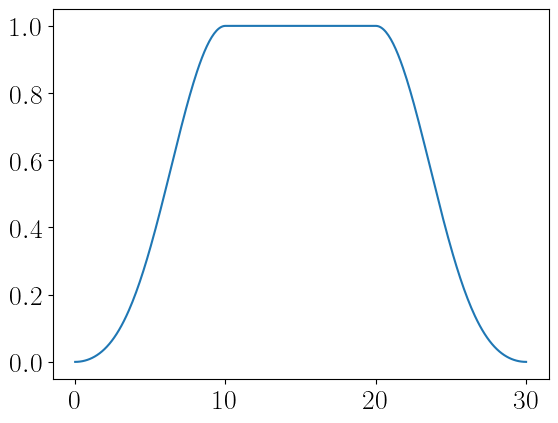

In [ ]:
N_points = 150
system = Ps_system(N_atoms = 1,N_points = N_points)
rabi0 = 2*np.pi*(200e-3)
chirp = 2*np.pi*(20e-3)
detuning = 0
direction = 1
pulse_duration = 10

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
#system.init_MBdistribution()
system.init_distribution_flattop()
system.init_states_ground()

laser = system.laserDict[0][1]
system.create_composite(laser)
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
#system.set_Hamiltonian_MT(args)
detuning = args["chirp"]

system.set_Hamiltonian_MT_general(args["rabi"],detuning,**args)



velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state
velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(velocity_array) # move all initial velocity states 1 bin to the right
target_states = qt.tensor(target_velocity_states,excited_state).unit() # define target states to be in the excited state

# the probability that a given velocity bin is in the excited state
excited_states = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[N_points:N_points*2][i]*target_states))[0][0] for i in range(N_points)])

#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = 0.1
t_fall = 0.1
lambda_a = 0.005
lambda_b = 0.05
S = lambda t: krotov.shapes.flattop(t, t_start=0, t_stop=3*pulse_duration, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman')


def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)
plt.plot(laser.tlist,[S(t) for t in laser.tlist])
plt.show()

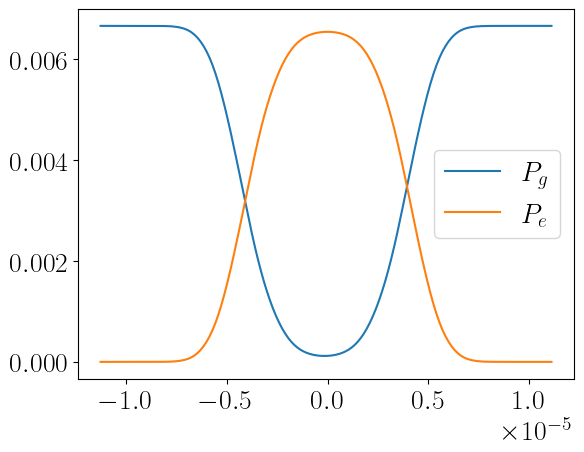

In [ ]:
result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
plt.plot(system.velocity_bins,np.asarray(result.expect)[0:150,-1],label=r"$P_g$")
plt.plot(system.velocity_bins,np.asarray(result.expect)[150:300,-1],label=r"$P_e$")
plt.legend()
plt.show()

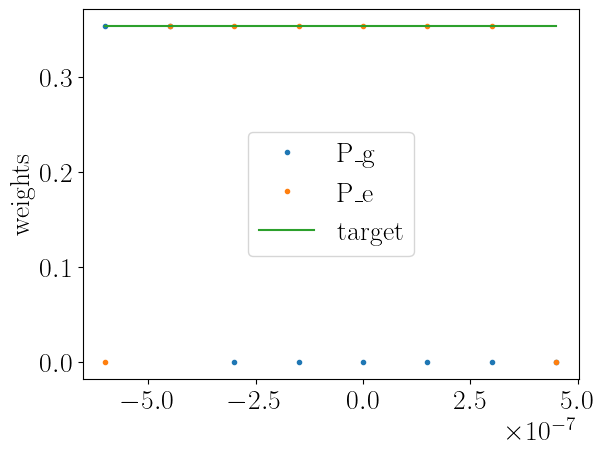

In [ ]:
#print(system.velocity_bins)
#plt.hist(system.velocity_bins,system.velocity_bins,weights=np.asarray(result.expect)[0:4,0],color="black")
plt.plot(system.velocity_bins,np.sqrt(result.expect)[0:N_points,-1],'.',label=r"P_g")
plt.plot(system.velocity_bins,np.sqrt(result.expect)[N_points:N_points*2,-1],'.',label=r"P_e")
plt.plot(system.velocity_bins,np.sqrt(excited_states),label=r"target")
plt.ylabel("weights")
plt.legend()
plt.show()


Text(0.5, 0, 'velocity [cm/ps]')

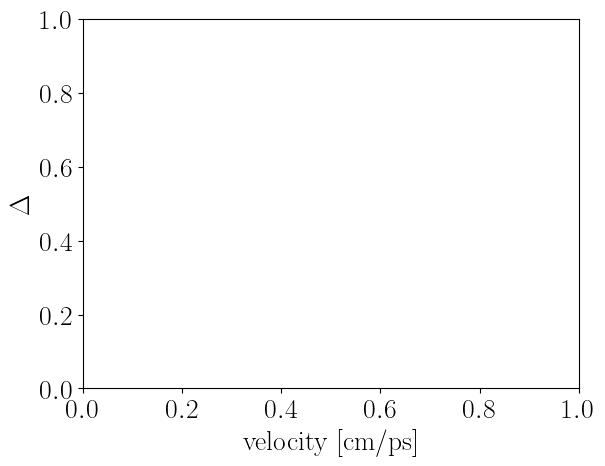

In [ ]:
#print(((np.abs(result.expect)[150:300,-1]-target_velocity_states)))
#print(((np.abs(result.expect)[150:300,-1]-target_velocity_states)*150*100)[10:])
#plt.plot(system.velocity_bins[10:],np.abs(((np.abs(result.expect)[150:300,-1]-target_velocity_states)*100)[10:]))
plt.ylabel(r"$\Delta$")
plt.xlabel("velocity [cm/ps]")

In [ ]:
a = qt.qdiags(system.velocity_bins,0)
b = qt.tensor(a,qt.qeye(2))
c = b.expm()
print(c)

Quantum object: dims = [[150, 2], [150, 2]], shape = (300, 300), type = oper, isherm = True
Qobj data =
[[0.99998875 0.         0.         ... 0.         0.         0.        ]
 [0.         0.99998875 0.         ... 0.         0.         0.        ]
 [0.         0.         0.9999889  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.00001095 0.         0.        ]
 [0.         0.         0.         ... 0.         1.0000111  0.        ]
 [0.         0.         0.         ... 0.         0.         1.0000111 ]]


In [ ]:
result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm)


In [ ]:
"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(N_points*system.internal_dims,dims=[[N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(N_points):
            eigenstate = qt.tensor(qt.basis(N_points,n),qt.basis(2,s))
            
            idx = system.internal_dims*n+s
            # does not seem to give convergence
            #chis_n_s = (fw_states_T.extract_states(idx).conj()*objective.target.extract_states(idx)).norm()*objective.target.extract_states(idx).norm()*eigenstate
            # gives convergence, but not good enough
            #chis_n_s = (fw_states_T.extract_states(idx).conj()*objective.target.extract_states(idx)).norm()*fw_states_T.extract_states(idx).norm()*eigenstate
            #chis_n_s = (fw_states_T.extract_states(idx).norm()**2*objective.target.extract_states(idx))*eigenstate
            #chis_n_s = fw_states_T.extract_states(idx).norm()**2*objective.target.extract_states(idx))*eigenstate
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]



[0.08164966+0.j]


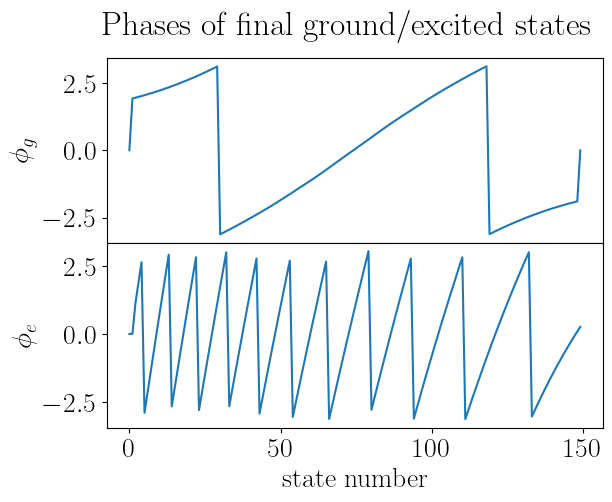

In [ ]:

final_states = result.states[-1]
#print(final_states)
#print(target_states)
#fidelity = fidelity_custom([final_states],[objective])
#chis = chis_custom([final_states],[objective])
#print(1-fidelity)
#print(chis[0])
ground_phases = []
excited_phases = []
final_states = np.asarray(final_states)
print(final_states[0])
for i in range(N_points):
    ground_phases.append(np.angle(final_states[i*2]))
    excited_phases.append(np.angle(final_states[i*2+1]))

fig,axes=plt.subplots(2,sharex=True,gridspec_kw={"hspace":0})
axes[0].plot(np.arange(N_points), ground_phases)
axes[1].plot(np.arange(N_points), excited_phases)
plt.xlabel("state number")
axes[0].set_ylabel(r"$\phi_g$")
axes[1].set_ylabel(r"$\phi_e$")
fig.suptitle("Phases of final ground/excited states")
#plt.savefig("figures/feb_2023/phases_final_state.jpg",bbox_inches="tight")
plt.show()
#overlap = np.sum(np.asarray(final_states.conj())*np.asarray(target_states))
#print(np.abs(overlap))
#print(np.angle(overlap))

#print(np.abs(krotov.optimize._overlap(final_states,target_states)))
#print(np.angle(krotov.optimize._overlap(final_states,target_states)))
#delta = np.abs(np.asarray(target_states)) - np.abs(np.asarray(final_states))
#states_bins = np.arange(300)
#plt.plot(states_bins,delta,'.')
#print(np.abs(krotov.optimize._overlap(initial_states,initial_states)))
#print(np.abs(krotov.optimize._overlap(target_states,target_states)))


In [ ]:
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=200,
    continue_from = old_result
)

(detuning) lambda_a = 0.005
(rabi0) lambda_b = 0.05
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.82e-02    0.00e+00   1.82e-02        n/a        n/a    12


KeyboardInterrupt: 

In [ ]:
opt_result.dump("data/krotov/full_excitation.pkl")
old_result = opt_result

(370,)
(371,)


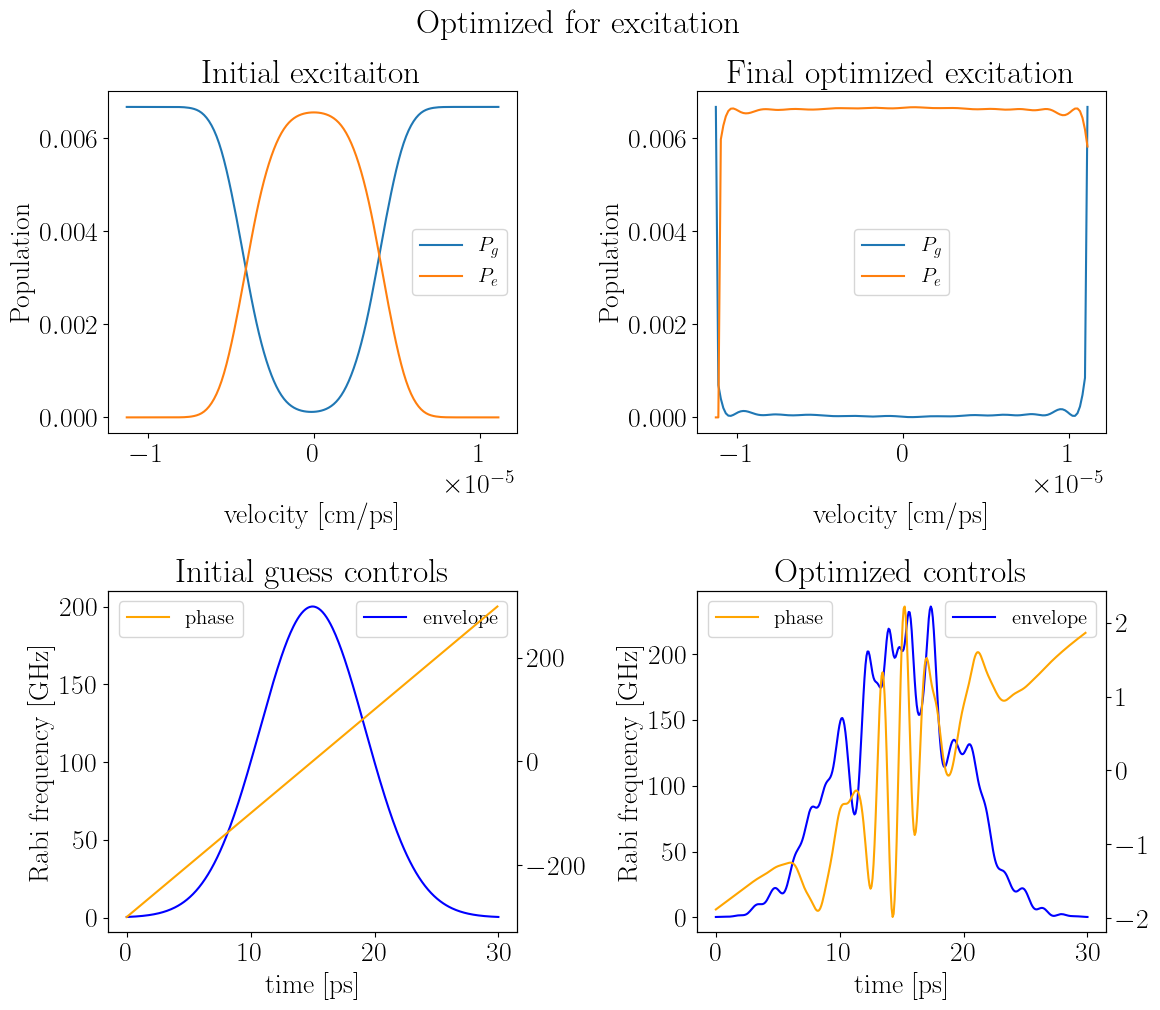

In [ ]:
#opt_result = krotov.result.Result().load("data/krotov/flattop3_flat_shape")
opt_dynamics = opt_result.optimized_objectives[0].mesolve(laser.tlist,e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:150,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[150:300,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
print(np.asarray(H[1][1][:-1]).shape)
print(laser.tlist.shape)
#Delta  = sp.integrate.cumtrapz(np.asarray(H[1][1][:-1]),laser.tlist[-1])

ax3.plot(laser.tlist[:-1],H[1][1][:-1]/(2*np.pi)*1e3,label="phase",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

#dDelta_dt = opt_result.optimized_controls[0]
#print(dDelta_dt.shape)
#Delta= sp.integrate.cumtrapz(dDelta_dt,laser.tlist)
#slope = np.gradient(phase)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],opt_result.optimized_controls[0][:-2],label="phase",color="orange")
##ax2.plot(laser.tlist,dDelta_dt,label="phase",color="orange")
#ax2.plot(laser.tlist[:-1],Delta,label=r"$\Delta(t)*t$",color="orange",ls="dashed")
#ax2.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for excitation",y=1.02)
#plt.savefig("figures/krotov/flattop_optimization.jpg",bbox_inches="tight")
plt.show()


In [ ]:
envelope_z = opt_result.optimized_controls[2]
#envelope_z = H[3][1]
handler = data_handler()
U = handler.calculate_pulse_energy(envelope_z,transverse_width = 0.5)
print("{:.3f} mJ".format(U*1e3))
# that is insanely large. Surely the calculation is wrong


268.22707034585943
0.009791516697777345
79.016 mJ


MB distribution

In [ ]:
N_points = 150
system = Ps_system(N_atoms = 1,N_points = N_points)
rabi0 = 2*np.pi*(200e-3)
chirp = 2*np.pi*(10e-3)
detuning = 0
direction = 1
pulse_duration = 8

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
system.init_MBdistribution()
#system.init_distribution_flattop()
system.init_states_ground()

laser = system.laserDict[0][1]
system.create_composite(laser)
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
system.set_Hamiltonian_MT(args)


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state
velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(velocity_array) # move all initial velocity states 1 bin to the right
target_states = qt.tensor(target_velocity_states,excited_state).unit() # define target states to be in the excited state

# the probability that a given velocity bin is in the excited state
excited_states = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[N_points:N_points*2][i]*target_states))[0][0] for i in range(N_points)])

#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = 7.5
t_fall = 7.5
lambda_a = 0.01
lambda_b = 0.05
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=t_stop, t_rise=t_rise, t_fall=t_fall, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)
# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)

AttributeError: 'Ps_system' object has no attribute 'init_MBdistribution'

In [ ]:
print("(chirp) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=100
)

(chirp) lambda_a = 0.01
(rabi0) lambda_b = 0.05
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     5.51e-01    0.00e+00   5.51e-01        n/a        n/a    10
1     4.42e-01    6.86e-02   5.10e-01  -1.09e-01  -4.08e-02    20
2     3.65e-01    5.11e-02   4.16e-01  -7.67e-02  -2.56e-02    20
3     3.21e-01    2.69e-02   3.48e-01  -4.40e-02  -1.70e-02    19
4     2.96e-01    1.28e-02   3.08e-01  -2.56e-02  -1.28e-02    20
5     2.79e-01    6.72e-03   2.86e-01  -1.67e-02  -1.00e-02    19
6     2.66e-01    4.40e-03   2.71e-01  -1.26e-02  -8.21e-03    19
7     2.56e-01    3.48e-03   2.59e-01  -1.06e-02  -7.09e-03    20
8     2.46e-01    3.08e-03   2.49e-01  -9.49e-03  -6.40e-03    20
9     2.37e-01    2.87e-03   2.40e-01  -8.81e-03  -5.93e-03    20
10    2.29e-01    2.74e-03   2.32e-01  -8.31e-03  -5.57e-03    20
11    2.21e-01    2.63e-03   2.24e-01  -7.90e-03  -5.27e-03    19
12    2.14e-01    2.52e-03   2.16e-01  -7.52e-03  -5.00e-03    19
13    2.06e-01    2.41e-03  

In [ ]:
opt_result.dump("data/krotov/MB")

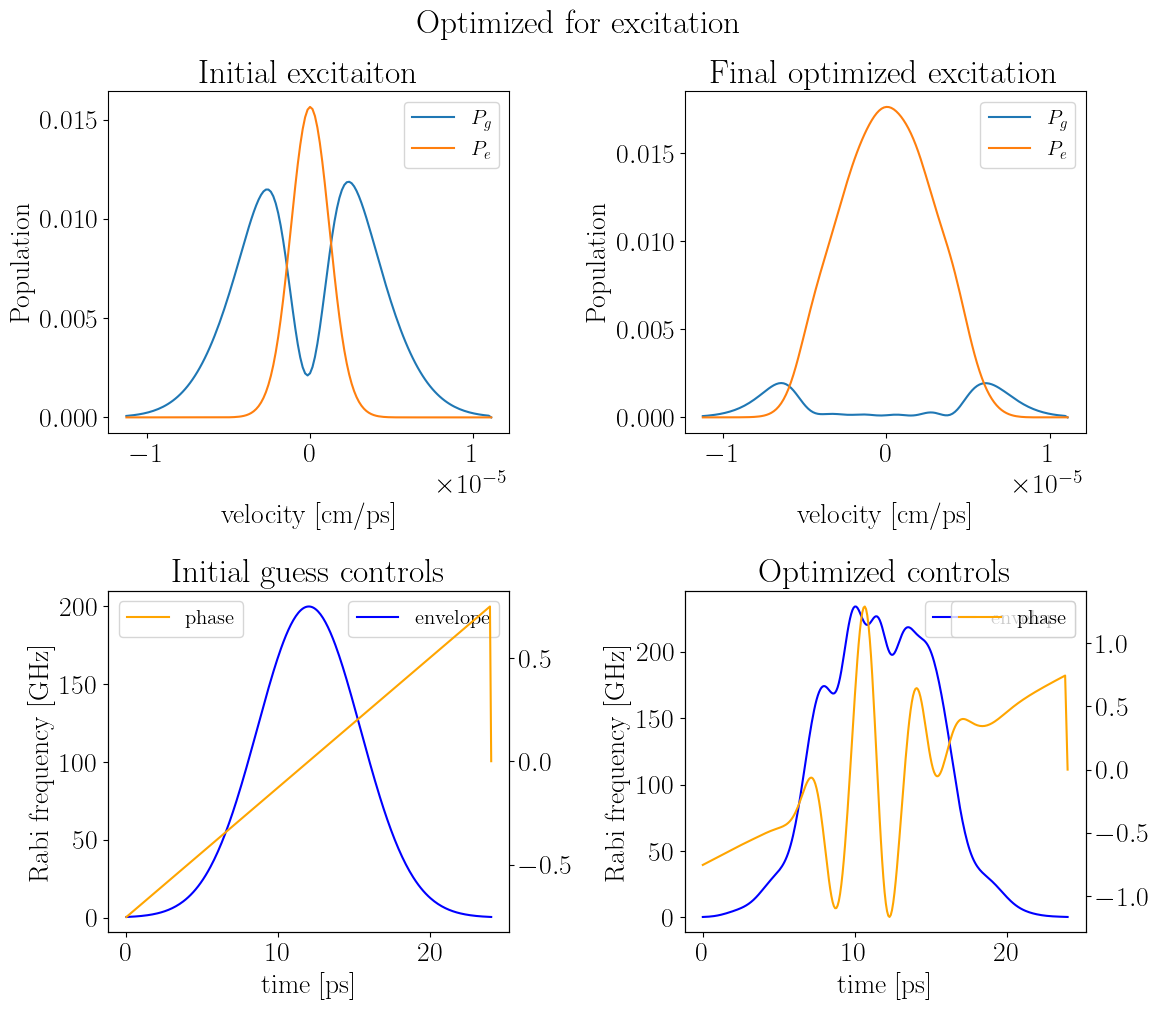

In [ ]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(laser.tlist,e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:150,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[150:300,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist,opt_result.optimized_controls[0],label="phase",color="orange")
#ax2.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for excitation",y=1.02)
#plt.savefig("figures/krotov/flattop_optimization.jpg",bbox_inches="tight")
plt.show()


# Finally investigating desymmetrization

151


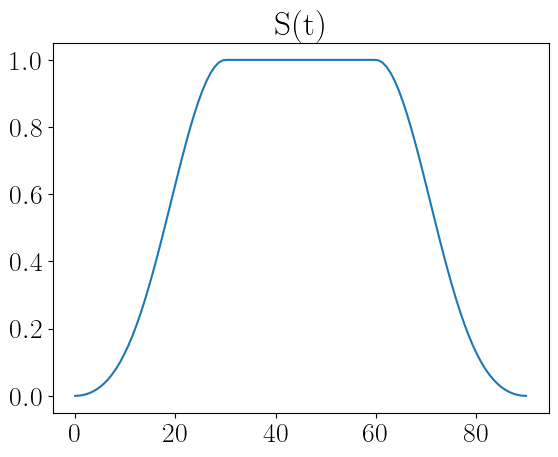

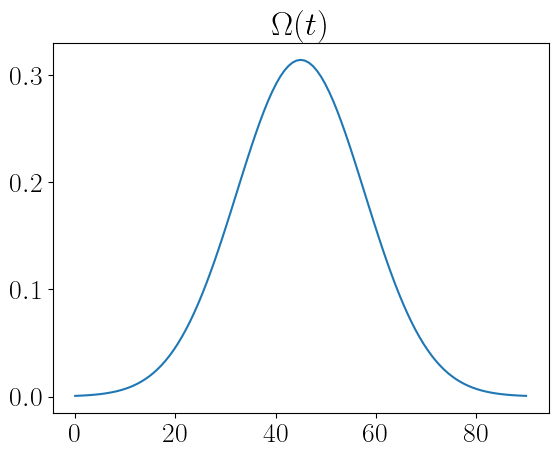

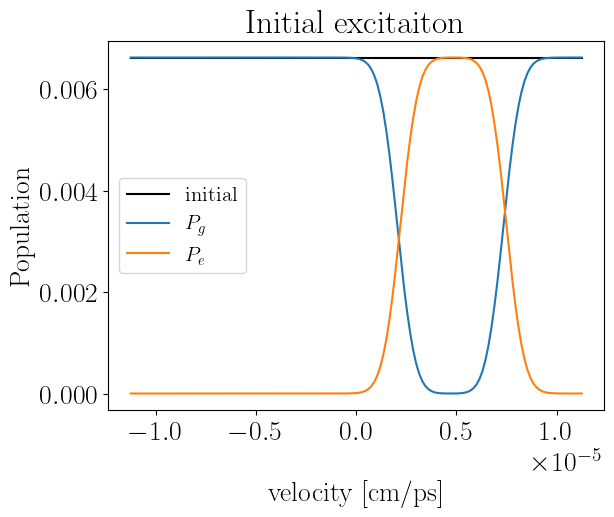

In [123]:
system = Ps_system(N_atoms = 1,N_points = 75)
rabi0 = 2*np.pi*(50e-3)
chirp = 2*np.pi*(5e-3)
detuning = 2*np.pi*(-200e-3)
direction = 1
pulse_duration = 30

laser_guess = {"scale": 1000,"label":"laser","order":0,"rabi0" : rabi0, "detuning0": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration)}
#system.init_distribution_MB()
system.init_distribution_flattop()
system.init_states_ground()

laser = laser_new(laser_guess)
system.create_composite()
# args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
#         "wavevector":laser.direction,
#         "rabi":np.asarray(laser.rabi(laser.tlist,None)),
#         "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
#         "selector1":laser.selector1,
#         "selector2":laser.selector2,
#         "tlist":laser.tlist,
#         "omega_L0":laser.omega_L0}
# phi = 2*np.pi*(150e-3)+args["chirp"]
system.set_Hamiltonian_MT_general_laser(laser)


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state


target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
print(target_velocity_array.size)
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= system.N_points/2+1 else 0 for i in range(system.N_points)]))
excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > system.N_points/2+1 else 0 for i in range(system.N_points)]))
target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points,system.N_points*2)])
#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.05 # detuning
lambda_b = 0.1 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)

plt.title("S(t)")
plt.plot(laser.tlist, [S(t) for t in laser.tlist])
plt.show()
plt.plot(laser.tlist,H[3][1])
plt.title(r"$\Omega(t)$")
plt.show()

unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

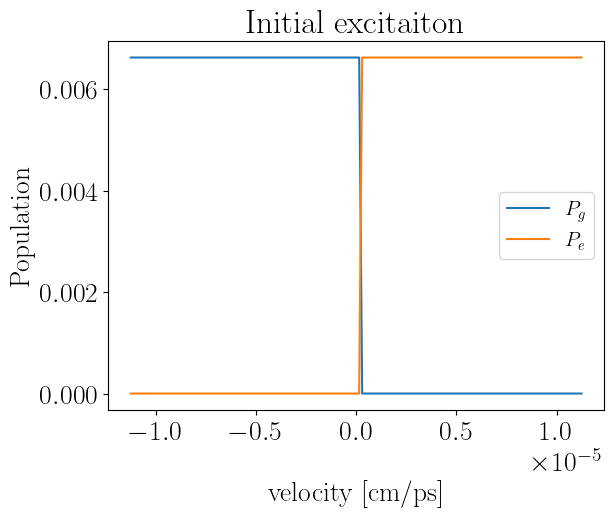

In [119]:
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, ground_states_tgt,label=r"$P_g$")
ax.plot(system.velocity_bins, excited_states_tgt,label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

In [132]:
#opt_result = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_30ps_detuned2.pkl")
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=500,
    continue_from = old_result
)

(detuning) lambda_a = 0.05
(rabi0) lambda_b = 0.1
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.01e-02    0.00e+00   8.01e-02        n/a        n/a     5
201   7.96e-02    2.53e-05   7.97e-02  -5.00e-04  -4.75e-04    10
202   7.91e-02    2.54e-05   7.92e-02  -4.99e-04  -4.74e-04    10
203   7.86e-02    2.55e-05   7.87e-02  -4.98e-04  -4.73e-04    10
204   7.81e-02    2.56e-05   7.82e-02  -4.97e-04  -4.72e-04    10
205   7.76e-02    2.56e-05   7.77e-02  -4.96e-04  -4.70e-04    10
206   7.71e-02    2.57e-05   7.72e-02  -4.95e-04  -4.69e-04    10
207   7.67e-02    2.58e-05   7.67e-02  -4.93e-04  -4.68e-04    10
208   7.62e-02    2.58e-05   7.62e-02  -4.92e-04  -4.66e-04    10
209   7.57e-02    2.59e-05   7.57e-02  -4.91e-04  -4.65e-04    10
210   7.52e-02    2.59e-05   7.52e-02  -4.89e-04  -4.63e-04    10
211   7.47e-02    2.60e-05   7.47e-02  -4.88e-04  -4.62e-04    10
212   7.42e-02    2.60e-05   7.42e-02  -4.86e-04  -4.60e-04    10
213   7.37e-02    2.61e-05

In [134]:
opt_result.dump("data/krotov/desymmetrization_flattop_optimization_30ps_red_detuned.pkl")
old_result = opt_result     

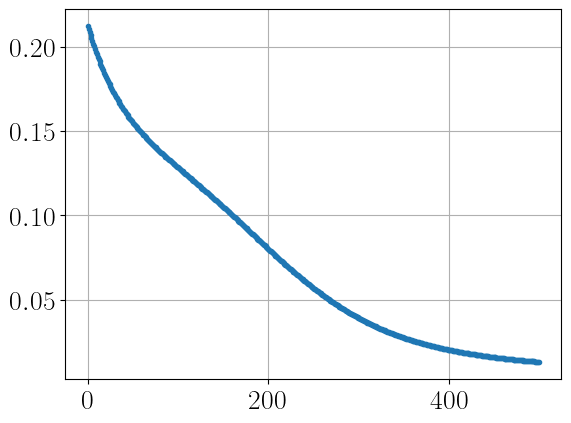

In [135]:
plt.plot(opt_result.iters,opt_result.info_vals,'.')
plt.grid()
plt.show()

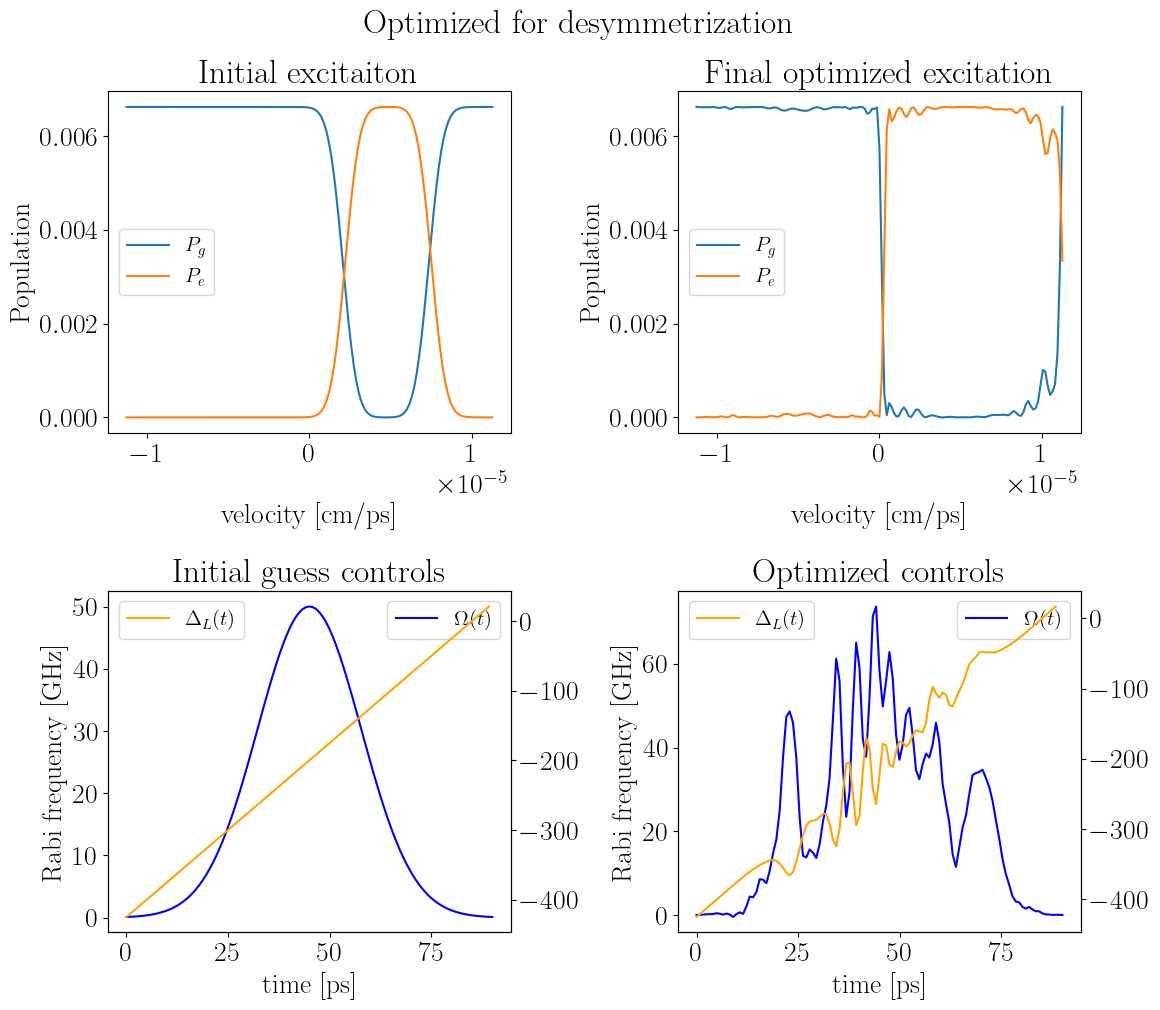

In [136]:
#opt_result = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_30ps_detuned2.pkl")
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist[:-1],H[1][1][:-1]*1e3/(2*np.pi),label=r"$\Delta_L(t)$",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

detuning = opt_result.optimized_controls[0]*1e3/(2*np.pi)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for desymmetrization",y=1.02)
#plt.savefig("figures/krotov/flattop_desymmetrization_50ps.jpg",bbox_inches="tight")
plt.show()


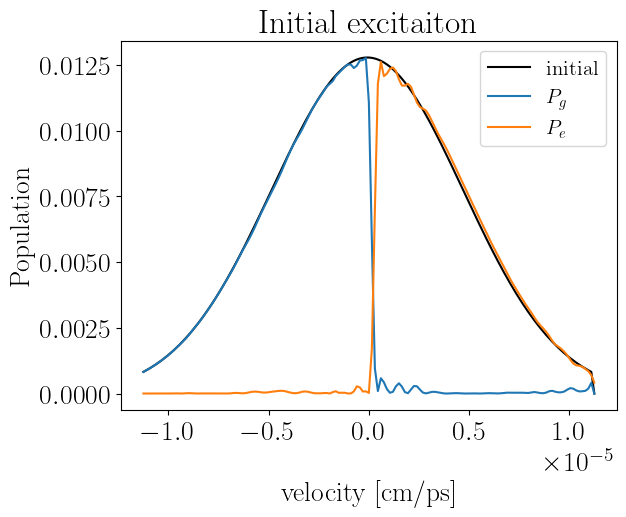

In [144]:
#opt_result = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_30ps_detuned2.pkl")
system = Ps_system(N_atoms = 1,N_points = 75)
system.init_distribution_MB()
#system.init_distribution_flattop()
system.init_states_ground()
system.create_composite()

detuning = opt_result.optimized_controls[0]
envelope = opt_result.optimized_controls[2]
tlist = opt_result.tlist
laser_guess = {
    "label":"desymmetrization",
    "order":0,
    "scale":1000,
    "envelope":envelope,
    "detuning":detuning,
    "unit_wavevector":1,
    "tlist":tlist
}
laser = laser_new(laser_guess)
system.set_Hamiltonian_MT_general_laser(laser)

velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

# result = qt.sesolve(tlist = opt_result.tlist,psi0 = system.states,H=system.H, e_ops=system.e_ops,options=opts)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[0:150,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[0:150,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(result.expect)[150:300,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
tlist = opt_result.tlist
target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= system.N_points//2+1 else 0 for i in range(system.N_points)]))
excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > system.N_points//2+1 else 0 for i in range(system.N_points)]))
target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(system.N_points,system.N_points*2)])
#print(target_states)
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.05 # detuning
lambda_b = 0.1 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(system.H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(system.H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(system.H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=system.states.unit(), target=target_states, H=system.H)
opts = qt.Options(store_states=True)
#unopt_result = qt.sesolve(tlist = opt_result.tlist,psi0=system.states,H=system.H,e_ops=system.e_ops,options=opts)
#unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=system.e_ops)
#test_final_states = unopt_result.states[-1]
# plt.plot(opt_result.tlist,system.H[1][1])
# plt.show()
# plt.plot(opt_result.tlist,system.H[3][1])
# plt.show()
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)
#print(J_T_custom([test_final_states],[objective]))

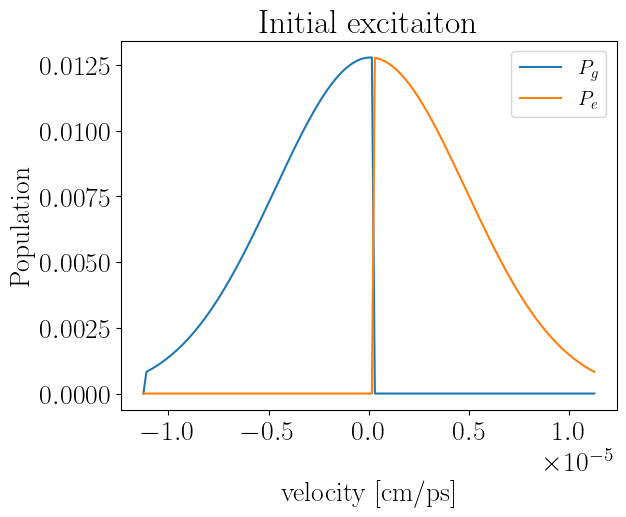

In [145]:
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, ground_states_tgt,label=r"$P_g$")
ax.plot(system.velocity_bins, excited_states_tgt,label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

In [146]:
print("(detuning) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist= tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=300,
    #continue_from = old_result
)

(detuning) lambda_a = 0.05
(rabi0) lambda_b = 0.1
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     7.27e-03    0.00e+00   7.27e-03        n/a        n/a     6
1     7.05e-03    3.53e-05   7.08e-03  -2.22e-04  -1.87e-04    12
2     6.86e-03    2.97e-05   6.89e-03  -1.86e-04  -1.56e-04    11
3     6.71e-03    2.51e-05   6.73e-03  -1.56e-04  -1.31e-04    11
4     6.58e-03    2.13e-05   6.60e-03  -1.31e-04  -1.10e-04    11
5     6.47e-03    1.82e-05   6.48e-03  -1.11e-04  -9.33e-05    11
6     6.37e-03    1.56e-05   6.39e-03  -9.51e-05  -7.95e-05    11
7     6.29e-03    1.35e-05   6.30e-03  -8.17e-05  -6.82e-05    11
8     6.22e-03    1.17e-05   6.23e-03  -7.06e-05  -5.89e-05    12
9     6.16e-03    1.02e-05   6.17e-03  -6.15e-05  -5.12e-05    11
10    6.10e-03    8.99e-06   6.11e-03  -5.39e-05  -4.49e-05    10
11    6.05e-03    7.95e-06   6.06e-03  -4.76e-05  -3.96e-05    11
12    6.01e-03    7.07e-06   6.02e-03  -4.23e-05  -3.53e-05    10
13    5.97e-03    6.33e-06

In [148]:
opt_result.dump("data/krotov/desymmetrization_MB_optimization_30ps_extended_blue_detuned.pkl")
old_result = opt_result     

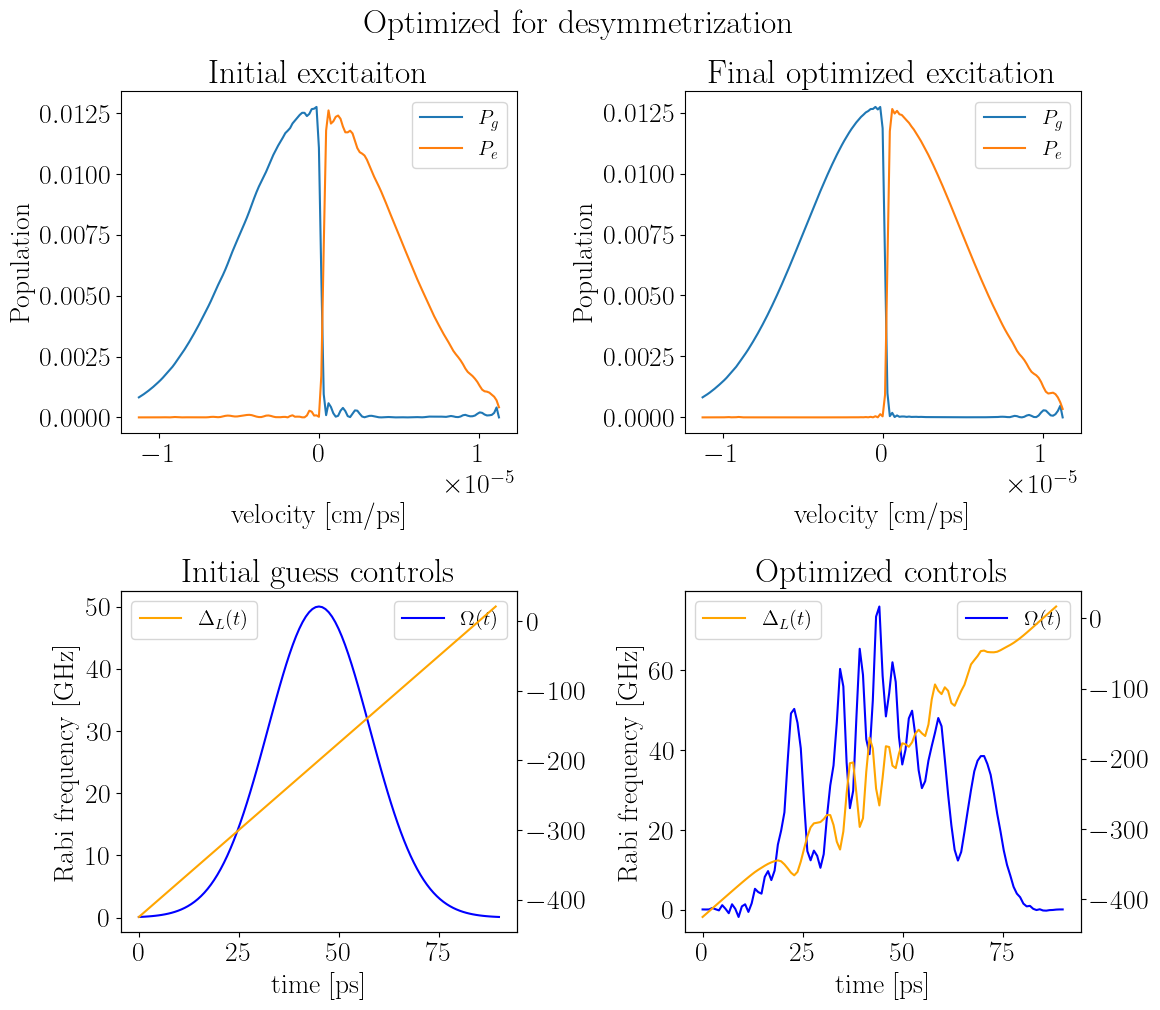

In [150]:
#opt_result = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_30ps_detuned2.pkl")
opt_dynamics = opt_result.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)

fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
#axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:system.N_points,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist[:-1],H[1][1][:-1]*1e3/(2*np.pi),label=r"$\Delta_L(t)$",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

detuning = opt_result.optimized_controls[0]*1e3/(2*np.pi)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label=r"$\Omega(t)$",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist[:-2],detuning[:-2],label=r"$\Delta_L(t)$",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for desymmetrization",y=1.02)
#plt.savefig("figures/krotov/flattop_desymmetrization_50ps.jpg",bbox_inches="tight")
plt.show()


# other things

In [80]:
opt_flattop = krotov.result.Result().load("data/krotov/flattop.pkl")
opt_MB = krotov.result.Result().load("data/krotov/MB.pkl")
opt_desymmetrization = krotov.result.Result().load("data/krotov/desymmetrization.pkl")


opt_dynamics_flattop = opt_flattop.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=system.e_ops)
opt_dynamics_MB = opt_MB.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=system.e_ops)
opt_dynamics_desymmetrization = opt_desymmetrization.optimized_objectives[0].propagate(laser.tlist,propagator=krotov.propagators.expm,e_ops=system.e_ops)

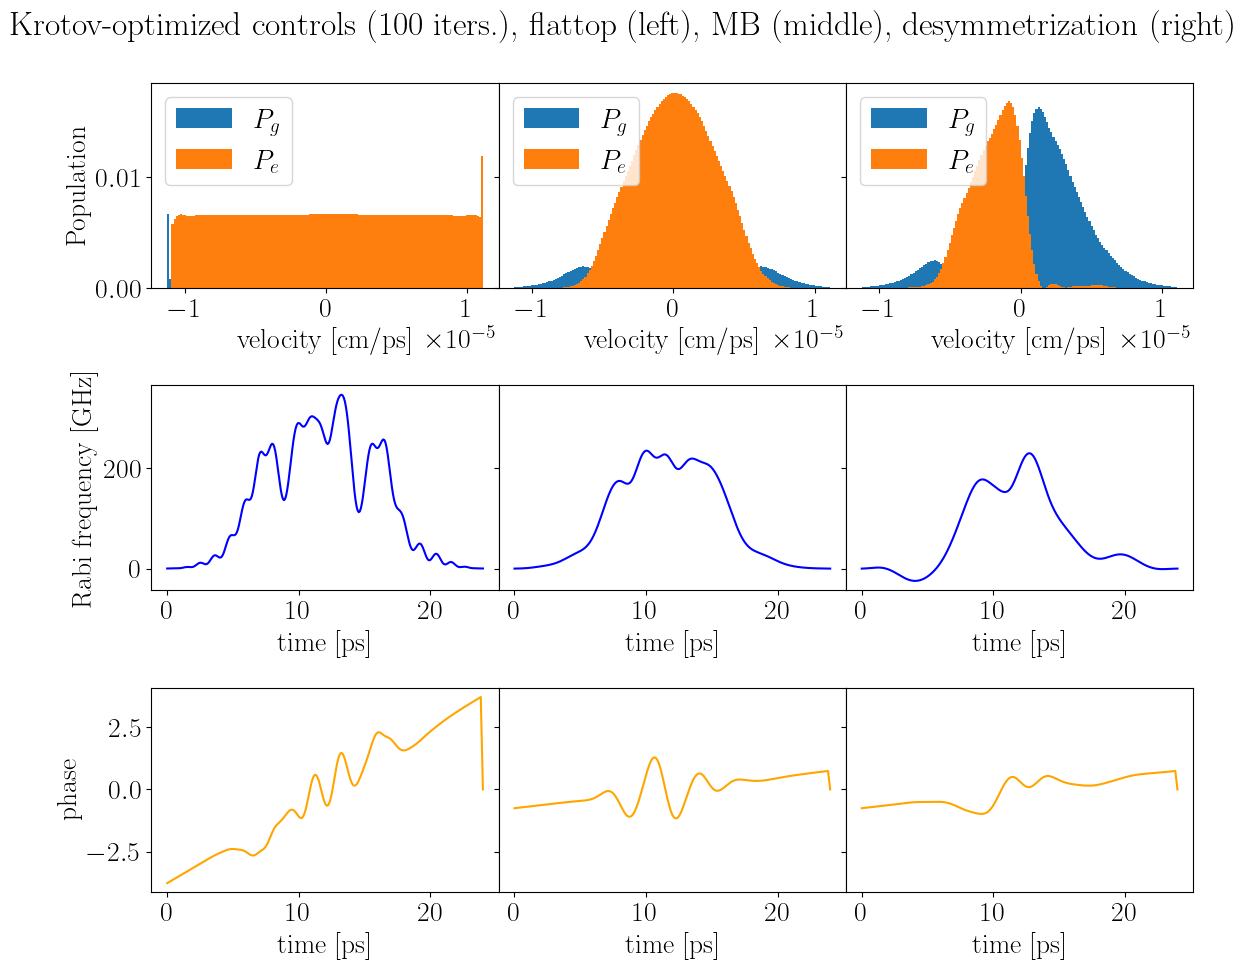

In [119]:
fig,axes = plt.subplots(3,3,figsize=(12,10),sharey='row',gridspec_kw={"wspace":0})
#print(np.asarray(opt_dynamics_flattop.expect[0:N_points]).shape)
#print(N_points)
axes[0,0].hist(system.velocity_bins,system.velocity_bins,weights=np.asarray(opt_dynamics_flattop.expect)[0:N_points,-1],label=r"$P_g$")
axes[0,0].hist(system.velocity_bins,system.velocity_bins,weights=np.asarray(opt_dynamics_flattop.expect)[N_points:N_points*2,-1],label=r"$P_e$")
axes[1,0].plot(laser.tlist,opt_flattop.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[2,0].plot(laser.tlist,opt_flattop.optimized_controls[0],label="phase",color="orange")
axes[1,0].set_xlabel("time [ps]")
axes[2,0].set_xlabel("time [ps]")
axes[0,0].set_xlabel("velocity [cm/ps]")
axes[0,0].set_ylabel("Population")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
axes[2,0].set_ylabel("phase")
axes[0,0].legend()

axes[0,1].hist(system.velocity_bins,system.velocity_bins,weights=np.asarray(opt_dynamics_MB.expect)[0:N_points,-1],label=r"$P_g$")
axes[0,1].hist(system.velocity_bins,system.velocity_bins,weights=np.asarray(opt_dynamics_MB.expect)[N_points:N_points*2,-1],label=r"$P_e$")
axes[1,1].plot(laser.tlist,opt_MB.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[2,1].set_xlabel("time [ps]")
#_desymmetrization.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,2].set_xlabel("time [ps]")
axes[2,2].set_xlabel("time [ps]")
axes[0,2].set_xlabel("velocity [cm/ps]")
axes[2,2].plot(laser.tlist,opt_desymmetrization.optimized_controls[0],label="phase",color="orange")
axes[0,2].legend()
fig.suptitle("Krotov-optimized controls (100 iters.), flattop (left), MB (middle), desymmetrization (right)")
fig.tight_layout()
#plt.savefig("figures/krotov/combined_results.jpg",bbox_inches="tight")
plt.show()

# More Krotov testing:

In [28]:
# Are the optimized controls for flattop good enough for the MB distribution?
system = Ps_system(N_points=150)
opt_flattop = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_50ps.dat")

system.init_distribution_MB()
#system.init_distribution_flattop()
system.init_states_ground()

rabis = opt_flattop.optimized_controls[2]
phi = opt_flattop.optimized_controls[0]
tlist = opt_flattop.tlist
system.create_composite(laser)
args = {"chirp": chirps,
        "wavevector": 1,
        "rabi": rabis,
        "selector1":np.zeros(tlist.size),
        "selector2":np.full(tlist.size,1),
        "tlist": tlist,
        "omega_L0":omega0}
system.set_Hamiltonian_MT_general(rabis,phi,**args)
opts = qt.Options(store_states=True)
result = qt.sesolve(system.H,tlist=tlist,psi0 = system.states,e_ops = system.e_ops,progress_bar=True,options=opts)

10.2%. Run time:   0.09s. Est. time left: 00:00:00:00
20.2%. Run time:   0.22s. Est. time left: 00:00:00:00
30.2%. Run time:   0.34s. Est. time left: 00:00:00:00
40.2%. Run time:   0.47s. Est. time left: 00:00:00:00
50.1%. Run time:   0.65s. Est. time left: 00:00:00:00
60.1%. Run time:   0.78s. Est. time left: 00:00:00:00
70.1%. Run time:   0.99s. Est. time left: 00:00:00:00
80.1%. Run time:   1.21s. Est. time left: 00:00:00:00
90.0%. Run time:   1.41s. Est. time left: 00:00:00:00
Total run time:   1.53s


In [37]:
print(fidelity_custom(result.states[-1], [objective]))

0.9896406896657902


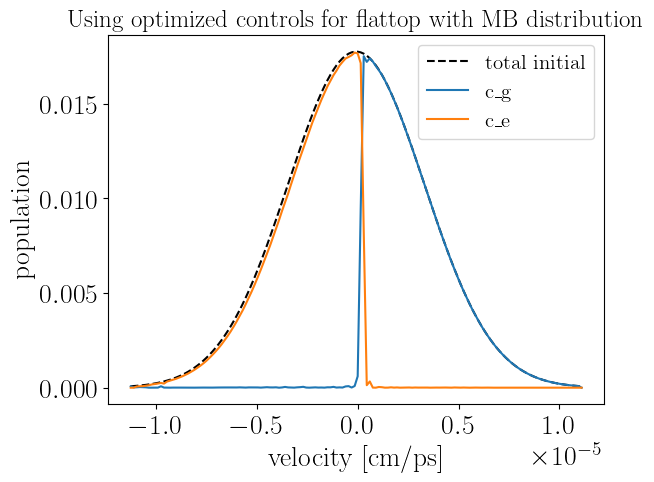

In [34]:
initial = np.asarray(result.expect)[0:150,0] + np.asarray(result.expect)[150:300,0]
c_g = np.asarray(result.expect)[0:150,-1]
c_e = np.asarray(result.expect)[150:300,-1]
plt.plot(system.velocity_bins,initial,label="total initial",color="black",ls="dashed")
plt.plot(system.velocity_bins,c_g,label="c_g")
plt.plot(system.velocity_bins,c_e,label="c_e")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
plt.title("Using optimized controls for flattop with MB distribution",fontsize=18)
#plt.savefig("figures/krotov/flattop_optimized_on_MB.jpg",bbox_inches="tight")
plt.legend(fontsize=15)


How good is the flattop-optimized desymmetrization for MB?

In [106]:
# Are the optimized controls for flattop good enough for the MB distribution?
system = Ps_system(N_points=150)
opt_flattop = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization.pkl")

system.init_MBdistribution()
#system.init_distribution_flattop()
system.init_states_ground()

rabis = opt_flattop.optimized_controls[2]
chirps = opt_flattop.optimized_controls[0]
tlist = opt_flattop.tlist
system.create_composite(laser)
args = {"chirp": chirps,
        "wavevector": 1,
        "rabi": rabis,
        "selector1":np.zeros(tlist.size),
        "selector2":np.full(tlist.size,1),
        "tlist": tlist,
        "omega_L0":omega0}
system.set_Hamiltonian_MT(args)
result = qt.sesolve(system.H,tlist=tlist,psi0 = system.states,e_ops = system.e_ops,progress_bar=True)

10.1%. Run time:   0.01s. Est. time left: 00:00:00:00
20.3%. Run time:   0.03s. Est. time left: 00:00:00:00
30.1%. Run time:   0.07s. Est. time left: 00:00:00:00
40.2%. Run time:   0.10s. Est. time left: 00:00:00:00
50.0%. Run time:   0.13s. Est. time left: 00:00:00:00
60.1%. Run time:   0.22s. Est. time left: 00:00:00:00
70.3%. Run time:   0.26s. Est. time left: 00:00:00:00
80.1%. Run time:   0.30s. Est. time left: 00:00:00:00
90.2%. Run time:   0.32s. Est. time left: 00:00:00:00
Total run time:   0.34s


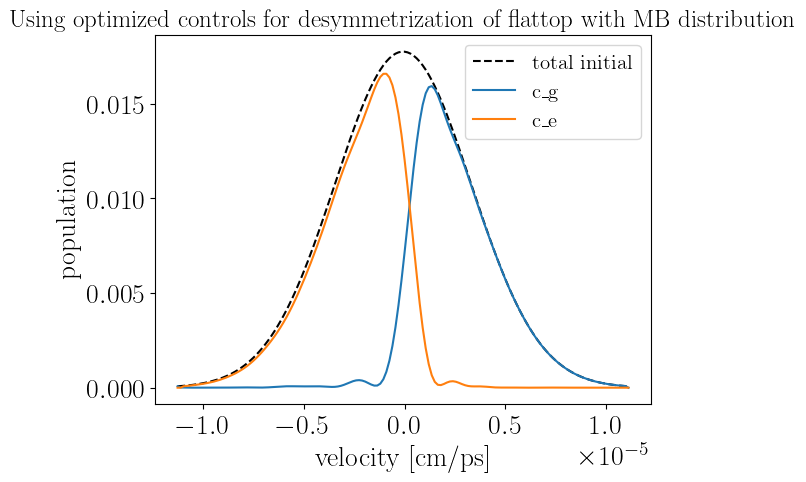

In [108]:
initial = np.asarray(result.expect)[0:150,0] + np.asarray(result.expect)[150:300,0]
c_g = np.asarray(result.expect)[0:150,-1]
c_e = np.asarray(result.expect)[150:300,-1]
plt.plot(system.velocity_bins,initial,label="total initial",color="black",ls="dashed")
plt.plot(system.velocity_bins,c_g,label="c_g")
plt.plot(system.velocity_bins,c_e,label="c_e")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
plt.title("Using optimized controls for desymmetrization of flattop with MB distribution",fontsize=18)
plt.savefig("figures/krotov/desymmetrization_optimized.jpg",bbox_inches="tight")
plt.legend(fontsize=15)


In [146]:
N_points = 150
system = Ps_system(N_atoms = 1,N_points = N_points)
rabi0 = 2*np.pi*(200e-3)
chirp = 2*np.pi*(10e-3)
detuning = 0
direction = 1
pulse_duration = 8

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
system.init_MBdistribution()
#system.init_distribution_flattop()
system.init_states_ground()

opt_desymmetrization = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization.pkl")
rabis = opt_desymmetrization.optimized_controls[2]
chirps = opt_desymmetrization.optimized_controls[0]
tlist = opt_desymmetrization.tlist
system.create_composite(laser)
args = {"chirp": chirps,
        "wavevector": 1,
        "rabi": rabis,
        "selector1":np.zeros(tlist.size),
        "selector2":np.full(tlist.size,1),
        "tlist": tlist,
        "omega_L0":omega0}
system.set_Hamiltonian_MT(args)


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state

target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > N_points//2+1 else 0 for i in range(N_points)]))
excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= N_points//2+1 else 0 for i in range(N_points)]))
target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(N_points,N_points*2)])
#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = 7.5
t_fall = 7.5
lambda_a = 0.001
lambda_b = 0.001
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=t_stop, t_rise=t_rise, t_fall=t_fall, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)
# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,0]+np.asarray(unopt_result.expect)[150:300,0],label=r"$initial$",color="black",ls="dashed")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)

In [147]:
print("(chirp) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=300,
    continue_from = old_result
)

(chirp) lambda_a = 0.001
(rabi0) lambda_b = 0.001
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     3.12e-02    0.00e+00   3.12e-02        n/a        n/a    10
251   3.12e-02    2.70e-04   3.15e-02   6.95e-06   2.77e-04    19 **


In [140]:
opt_result.dump("data/krotov/desymmetrization_MB_optimization_false.pkl")
old_result = opt_result

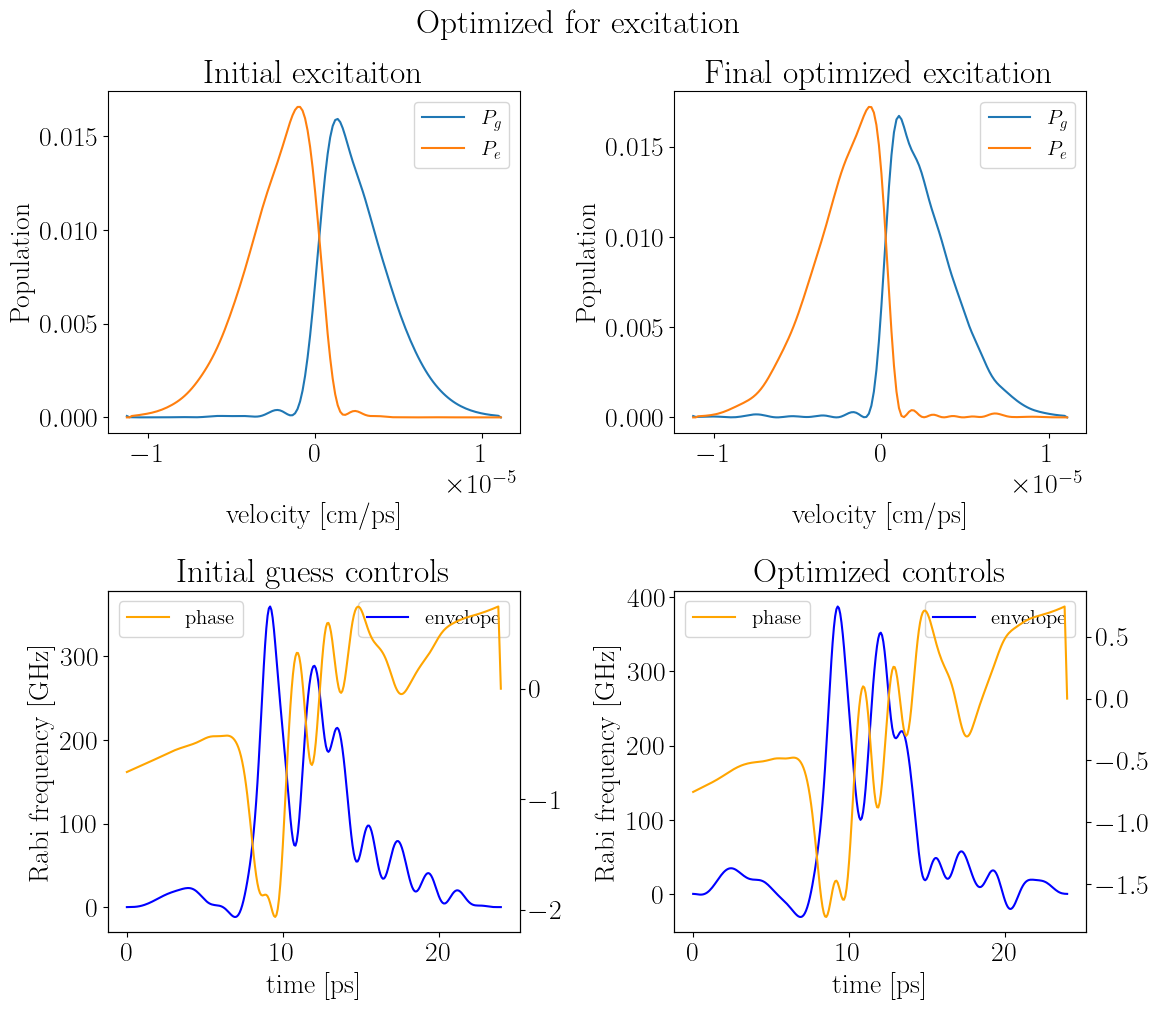

In [139]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(laser.tlist,e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:150,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[150:300,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist,opt_result.optimized_controls[0],label="phase",color="orange")
#ax2.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for excitation",y=1.02)
#plt.savefig("figures/krotov/flattop_optimization.jpg",bbox_inches="tight")
plt.show()


# Optimizing towards notched spectrum

In [31]:
N_points = 150
system = Ps_system(N_atoms = 1,N_points = N_points)
rabi0 = 2*np.pi*(200e-3)
chirp = 2*np.pi*(10e-3)
detuning = 0
direction = 1
pulse_duration = 8

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
#system.init_MBdistribution()
system.init_distribution_flattop()
system.init_states_ground()

laser = system.laserDict[0][1]
system.create_composite(laser)
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
system.set_Hamiltonian_MT(args)


velocity_states = qt.Qobj(system.initial_pop) # distribute initial velocity states as a Maxwell-Boltzmann distribution
ground_state = qt.basis(system.internal_dims,0) # Ground state is represented as (1,0)
excited_state = qt.basis(system.internal_dims,1) # Excited state is represented as (0,1)

initial_states = qt.tensor(velocity_states,ground_state).unit() # define initial states to be in the ground state

target_velocity_array = np.roll(system.initial_pop,direction)#; velocity_array[0] = 0
target_velocity_states = qt.Qobj(target_velocity_array) # move all initial velocity states 1 bin to the right
ket_1S = qt.basis(system.internal_dims,0)
ket_2P = qt.basis(system.internal_dims,1)
right_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i > N_points/2+0.05*N_points else 0 for i in range(N_points)]))
left_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i <= N_points/2-0.05*N_points else 0 for i in range(N_points)]))
target_states = (qt.tensor(left_kets_vel+right_kets_vel,ket_2P) ).unit()
# the probability that a given velocity bin is in the excited state

ground_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(N_points)])
excited_states_tgt = np.asarray([np.abs(np.asarray(target_states.dag()*system.e_ops[i]*target_states))[0][0] for i in range(N_points,N_points*2)])
#print(target_states)
H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = 7.5
t_fall = 7.5
lambda_a = 0.002
lambda_b = 0.002
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=t_stop, t_rise=t_rise, t_fall=t_fall, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)
# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)

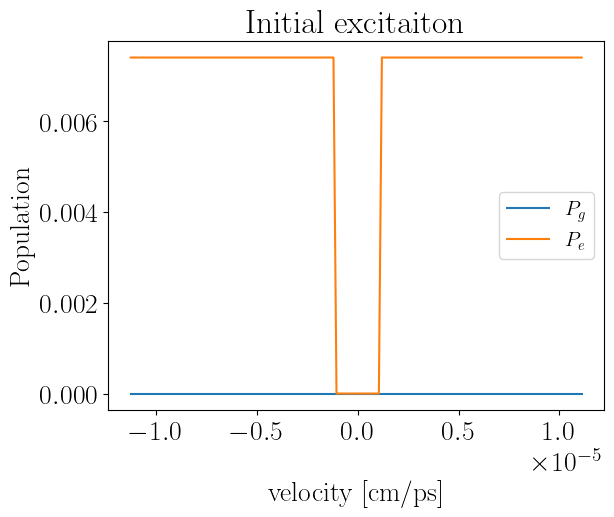

In [32]:
fig,ax = plt.subplots()
ax.set_title("Initial excitaiton")
ax.plot(system.velocity_bins, ground_states_tgt,label=r"$P_g$")
ax.plot(system.velocity_bins, excited_states_tgt,label=r"$P_e$")
ax.set_xlabel("velocity [cm/ps]",labelpad=25)
ax.set_ylabel("Population")
ax.legend(fontsize=15)

In [34]:
print("(chirp) lambda_a = {}".format(lambda_a))
print("(rabi0) lambda_b = {}".format(lambda_b))
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options=pulse_options,
    tlist=laser.tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=chis_custom,
    info_hook=krotov.info_hooks.print_table(J_T=J_T_custom),
        check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error),
    iter_stop=100,
)

(chirp) lambda_a = 0.002
(rabi0) lambda_b = 0.002
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     8.89e-01    0.00e+00   8.89e-01        n/a        n/a    11
1     8.36e-01    5.25e-02   8.88e-01  -5.32e-02  -7.87e-04    22
2     7.65e-01    8.37e-02   8.49e-01  -7.07e-02   1.29e-02    20 *
3     6.98e-01    9.70e-02   7.95e-01  -6.73e-02   2.96e-02    19 *
4     6.37e-01    8.51e-02   7.22e-01  -6.07e-02   2.44e-02    19 *
5     5.75e-01    7.53e-02   6.51e-01  -6.19e-02   1.34e-02    20 *
6     5.11e-01    7.05e-02   5.82e-01  -6.39e-02   6.67e-03    21 *
7     4.46e-01    7.04e-02   5.16e-01  -6.55e-02   4.93e-03    20 *
8     3.76e-01    8.43e-02   4.61e-01  -6.96e-02   1.47e-02    21 *
9     3.08e-01    1.05e-01   4.13e-01  -6.83e-02   3.71e-02    20 *
10    2.55e-01    1.02e-01   3.57e-01  -5.31e-02   4.88e-02    19 *
11    2.19e-01    7.52e-02   2.94e-01  -3.57e-02   3.96e-02    20 *
12    1.94e-01    5.44e-02   2.48e-01  -2.54e-02   2.90e-02    21 *
13  

In [35]:
opt_result.dump("data/krotov/notched_optimization.pkl")
old_result = opt_result

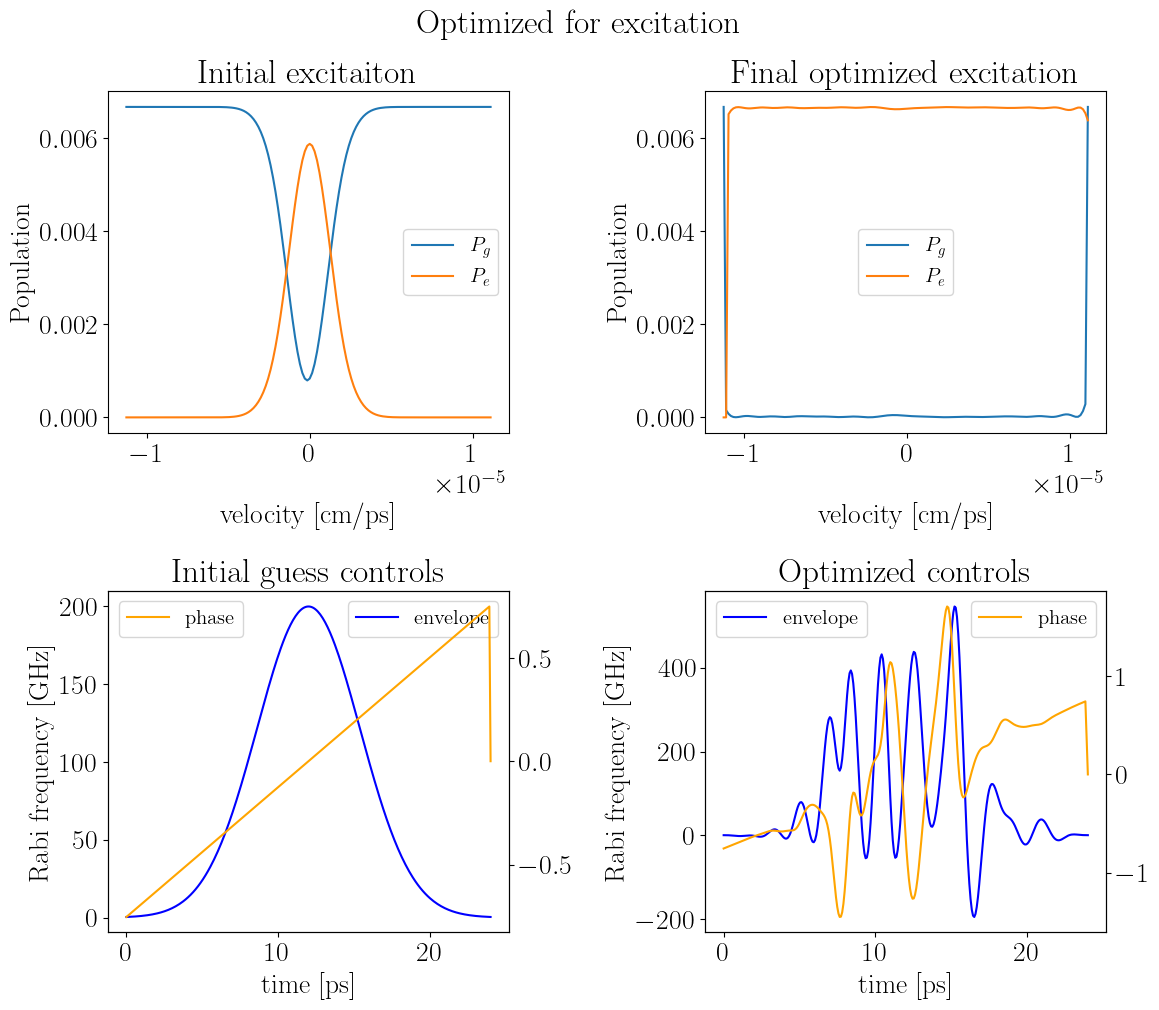

In [36]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(laser.tlist,e_ops=system.e_ops)
unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
fig,axes = plt.subplots(2,2,figsize=(12,10))

axes[0,0].set_title("Initial excitaiton")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:150,-1],label=r"$P_g$")
axes[0,0].plot(system.velocity_bins, np.asarray(unopt_result.expect)[150:300,-1],label=r"$P_e$")
axes[0,0].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,0].set_ylabel("Population")
axes[0,0].legend(fontsize=15)

axes[0,1].set_title("Final optimized excitation")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[0:150,-1],label=r"$P_g$")
axes[0,1].plot(system.velocity_bins, np.asarray(opt_dynamics.expect)[150:300,-1],label=r"$P_e$")
axes[0,1].set_xlabel("velocity [cm/ps]",labelpad=25)
axes[0,1].set_ylabel("Population")
axes[0,1].legend(fontsize=15)

axes[1,0].set_title("Initial guess controls")
axes[1,0].plot(laser.tlist,H[3][1]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,0].set_xlabel("time [ps]")
axes[1,0].set_ylabel("Rabi frequency [GHz]")
ax3 = axes[1,0].twinx()
ax3.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,0].legend(fontsize=15)
ax3.legend(fontsize=15)

axes[1,1].set_title("Optimized controls")
axes[1,1].plot(laser.tlist,opt_result.optimized_controls[2]/(2*np.pi)*1e3,label="envelope",color="blue")
axes[1,1].set_xlabel("time [ps]")
axes[1,1].set_ylabel("Rabi frequency [GHz]")
ax2 = axes[1,1].twinx()
ax2.plot(laser.tlist,opt_result.optimized_controls[0],label="phase",color="orange")
#ax2.plot(laser.tlist,H[1][1],label="phase",color="orange")
axes[1,1].legend(fontsize=15)
ax2.legend(fontsize=15)

fig.tight_layout()
fig.suptitle("Optimized for excitation",y=1.02)
#plt.savefig("figures/krotov/flattop_optimization.jpg",bbox_inches="tight")
plt.show()


# Desymmetrization

In [ ]:
opt_flattop = krotov.result.Result().load("data/krotov/desymmetrization_flattop_optimization_50ps.dat")